## Access the Downloaded Data

In [62]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from astropy import units

from shared_astro_utils import matching_utils  # personal PyPI package

In [21]:
def remove_bad_values(x):
    return x[(~np.isnan(x)) & (np.isfinite(x))]

In [22]:
# data_loc = 'catalogs/nsa_v1_0_1_ossy_ukidss_dr9_las.fits'
data_loc = 'catalogs/nsa_v1_0_1_ossy_ukidss_dr9_las_allwise.fits'

Including AllWISE at 5 arcseconds, we have 182128 rows. This is down only a few hundred from 182956.

In [23]:
data = Table.read(data_loc)

In [24]:
pd.Series(data['PROGRAMNAME']).value_counts()

b'legacy                     '    180318
b'                           '       916
b'southern                   '       474
b'boss                       '       268
b'commissioning              '        46
b'lowz                       '        34
b'preboss                    '        33
b'lowz_lrg                   '        32
b'segue2                     '         2
b'seguefaint                 '         2
b'lowz_loveday               '         2
b'photoz                     '         1
dtype: int64

In [25]:
data['PROGRAMNAME'] = list(map(lambda x: x.strip(), data['PROGRAMNAME']))
data = data[data['PROGRAMNAME'] == 'legacy']

In [26]:
assert len(data) == 180318

#### Redshifts (from NSA)

In [27]:
n_bins = 50

Text(0,0.5,'Galaxy Count')

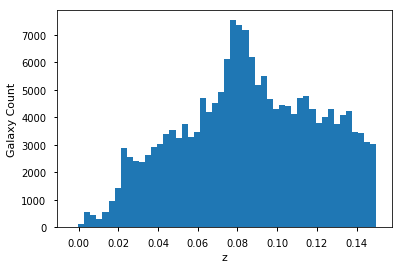

In [28]:
plt.hist(data['Z'], bins=n_bins)
plt.xlabel('z')
plt.ylabel('Galaxy Count')

We might expect a peak from the balance between completeness and volume probed. This does seem kinda sharp nonetheless.

#### Optical Absolute Magnitudes (from NSA)

In [29]:
ordered_sdss_bands = ['F', 'N', 'U', 'G', 'R', 'I', 'Z']
sdss_mags = list(map(lambda x: x + '_MAG_ABSOLUTE', ordered_sdss_bands))

for n, abs_mag_name in enumerate(sdss_mags):
    data[abs_mag_name] = data['ELPETRO_ABSMAG'][:, n]


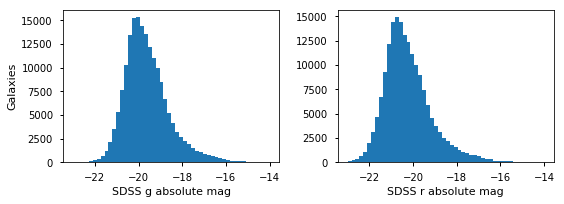

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))

g_band_mags = np.array(data['G_MAG_ABSOLUTE'])
g_band_mags = remove_bad_values(g_band_mags)
g_band_mags = g_band_mags[(g_band_mags < -14) & (g_band_mags > -23)]  # remove crazy tails

r_band_mags = np.array(data['R_MAG_ABSOLUTE'])
r_band_mags = remove_bad_values(r_band_mags)
r_band_mags = r_band_mags[(r_band_mags < -14) & (r_band_mags > -23)]  # remove crazy tails

axes[0].set_ylabel('Galaxies')

axes[0].hist(g_band_mags, bins=n_bins)
axes[0].set_xlabel('SDSS g absolute mag')


axes[1].hist(r_band_mags, bins=n_bins)
axes[1].set_xlabel('SDSS r absolute mag')

fig.tight_layout()

#### Optical Apparent Magnitudes (from NSA)

This is currently estimated from the NSA estimated absolute magnitudes - but this is obviously backwards. It would be better to get these direct from SDSS observations - they are surely recorded somewhere.

Chris says the apparent magnitudes can be grabbed from a hidden casjobs table called 'galaxies'. I should go get these instead of working 'backwards' with cosmology.

In [31]:
data['DISTANCE_MODULUS'] = cosmo.distmod(data['Z'])
data['DISTANCE_MODULUS_LIST'] = np.array(list(map(lambda x: [x for n in range(7)], data['DISTANCE_MODULUS'])))
data['ELPETRO_APPARENT_MAG'] = data['ELPETRO_ABSMAG'] + data['DISTANCE_MODULUS_LIST']

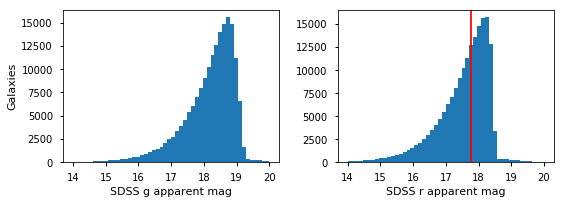

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3))

g_band_mags = np.array(data['ELPETRO_APPARENT_MAG'])[:, 3] # g is NSA 4th value: FNugriz
g_band_mags = remove_bad_values(g_band_mags)
g_band_mags = g_band_mags[(g_band_mags > 14) & (g_band_mags < 20)]  # remove crazy tails

r_band_mags = np.array(data['ELPETRO_APPARENT_MAG'])[:, 4] # r is NSA 5th value: FNugriz
r_band_mags = remove_bad_values(r_band_mags)
r_band_mags = r_band_mags[(r_band_mags > 14) & (r_band_mags < 20)]  # remove crazy tails

axes[0].set_ylabel('Galaxies')

axes[0].hist(g_band_mags, bins=n_bins)
axes[0].set_xlabel('SDSS g apparent mag')


axes[1].hist(r_band_mags, bins=n_bins)
axes[1].set_xlabel('SDSS r apparent mag')
axes[1].axvline(17.77, c='r')

fig.tight_layout()

The sudden drop is (we think) due to the SDSS selection cut. It's slightly deeper than r = 17.77 because leftover fibres were used to image fainter galaxies (according to Chris). The simplest thing to do would be to artifically impose the r = 17.77 cut. It would be better to include the fainter galaxies, but I'm not sure where to look for the selection function.

I still need to see how this matches up to GZ morphology selections. If the fainter ones would be excluded anyway, it's not useful.

#### UKIDSS Apparent Magnitudes

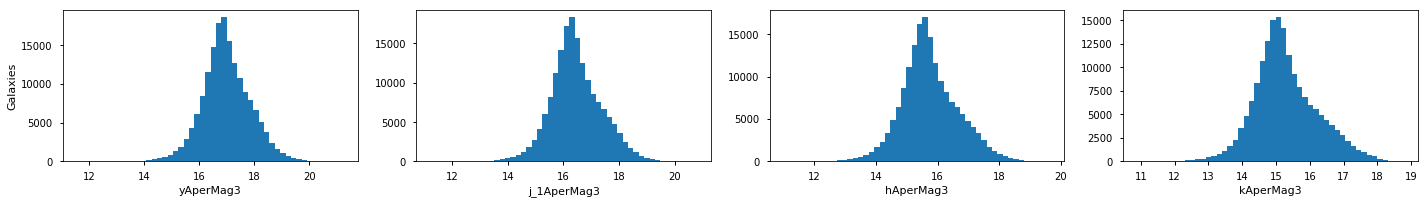

In [33]:
ukidss_cols = [
    'JName',
    'ra_xmatch',
    'dec_xmatch',
    'yAperMag3',
    'j_1AperMag3',
    'hAperMag3',
    'kAperMag3',
    'yAperMag3Err',
    'j_1AperMag3Err',
    'hAperMag3Err',
    'kAperMag3Err',
    'sourceID',
    'mode',
    'epoch',
    'mergedClass',
    'angDist',
    'SDSS_ID'
]


apparent_mag_bands = [
    'yAperMag3',
    'j_1AperMag3',
    'hAperMag3',
    'kAperMag3',
]

fig, axes = plt.subplots(ncols=len(apparent_mag_bands), figsize=(20, 3))
for axes_n, mag in enumerate(apparent_mag_bands):
    axes[axes_n].hist(remove_bad_values(data[mag]), bins=50)
    axes[axes_n].set_xlabel(mag)
axes[0].set_ylabel('Galaxies')
fig.tight_layout()

"Y=20.2, J=19.6, H=18.8, K=18.2" is indeed the deepest that UKIDSS has any objects.

The data release papers claim this is the limit for a 5 sigma detection in 2 arcsec aperture. But surely galaxies only get more common at fainter depths - as seen with SDSS. Why the gradual tail-off?

The answer might be that the SDSS spectroscopy cut is brighter than the UKIDSS depth limit, causing SDSS to have a sharp cut-off and UKIDSS to have a gradual decline (as faint galaxies become missed by SDSS, even though they are imaged by UKIDSS).

If so, and we plotted UKIDSS *without* cross-matching, we would expect to see a continual increase to the limiting depth and then a sharp cut-off. 

**TODO: I should check this.**


#### UKIDSS Absolute Magnitudes

Here, it actually makes sense to use cosmology to convert apparent magnitudes to (approximate i.e. without k-correction) absolute magnitues

In [34]:
ukidss_abs_mag_bands = [
    'Y_MAG_ABSOLUTE',
    'J_MAG_ABSOLUTE',
    'H_MAG_ABSOLUTE',
    'K_MAG_ABSOLUTE'
]

# Note: these are not k-corrected
data['Y_MAG_ABSOLUTE'] = data['yAperMag3'] - data['DISTANCE_MODULUS']
data['J_MAG_ABSOLUTE'] = data['j_1AperMag3'] - data['DISTANCE_MODULUS']
data['H_MAG_ABSOLUTE'] = data['hAperMag3'] - data['DISTANCE_MODULUS']
data['K_MAG_ABSOLUTE'] = data['kAperMag3'] - data['DISTANCE_MODULUS']

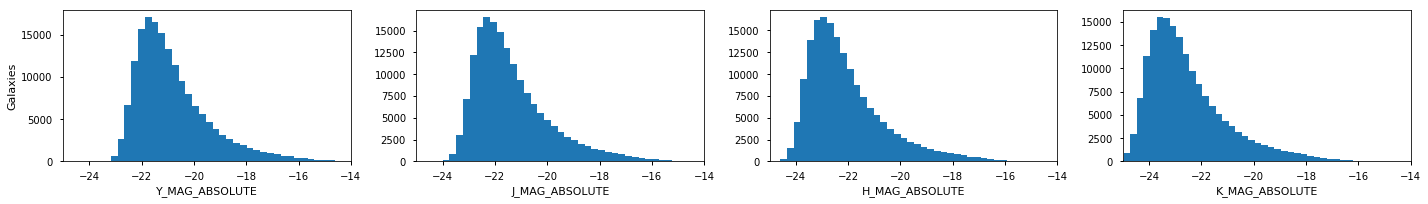

In [35]:
fig, axes = plt.subplots(ncols=len(ukidss_abs_mag_bands), figsize=(20, 3))
for axes_n, mag in enumerate(ukidss_abs_mag_bands):
    axes[axes_n].hist(remove_bad_values(data[mag]), bins=100)
    axes[axes_n].set_xlabel(mag)
    axes[axes_n].set_xlim([-25, -14])
axes[0].set_ylabel('Galaxies')
fig.tight_layout()

#### Derived Mass (from NSA)

These are derived through the spectra without OSSY re-processing - presumably from the originals or from MPA-JHU.

**TODO: I should look up exactly where this comes from**

/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

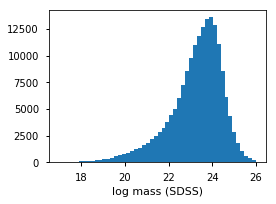

In [36]:
log_mass = np.log(remove_bad_values(data['ELPETRO_MASS']))
log_mass = log_mass[(log_mass > 17) & (log_mass < 26)]  # remove crazy tails

plt.clf()
fig, axes = plt.subplots(ncols=1, figsize=(4, 3))
axes.hist(log_mass, bins=n_bins)
axes.set_xlabel('log mass (SDSS)')
# axes[0].set_ylabel('Galaxies')
fig.tight_layout()

#### Color-Magnitude Diagram

In [37]:
# NSA columns with 7 values are for FNugriz values
g_mag = - np.array(data['ELPETRO_ABSMAG'])[:, 3]
r_mag = - np.array(data['ELPETRO_ABSMAG'])[:, 4]
g_r_color = pd.Series(g_mag - r_mag)

color_mag_df = pd.DataFrame(data={'g_r_color': g_r_color, 'g_mag': g_mag})
color_mag_df = color_mag_df.dropna(how='any')
color_mag_df = color_mag_df[(color_mag_df['g_mag'] > 16) & (color_mag_df['g_mag'] < 22)]
color_mag_df = color_mag_df[(color_mag_df['g_r_color'] > -1.) & (color_mag_df['g_r_color'] < 0.)]

/data/miniconda3/envs/find_agn/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


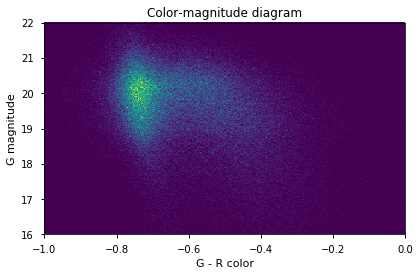

In [38]:
plt.hist2d(color_mag_df['g_r_color'], color_mag_df['g_mag'], bins=300)
plt.xlabel('G - R color')
plt.ylabel('G magnitude')
plt.title('Color-magnitude diagram')
plt.tight_layout()

#### OSSY Sanity Check: H-Alpha Lines

0 of 180318 galaxies have bad/missing h-alpha OSSY values
7007 of 180318 galaxies have no h-alpha line


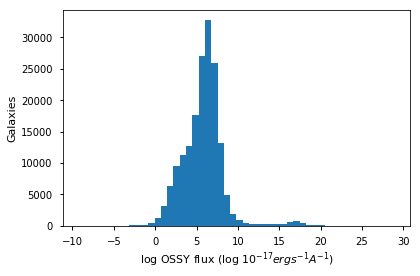

In [39]:
h_alpha_raw = pd.Series(data['HA_6562'])
h_alpha = remove_bad_values(h_alpha_raw)
print('{} of {} galaxies have bad/missing h-alpha OSSY values'.format(len(h_alpha) - len(h_alpha_raw), len(h_alpha_raw)))
print('{} of {} galaxies have no h-alpha line'.format(np.sum(h_alpha == 0), len(h_alpha)))
_ = plt.hist(np.log(h_alpha[h_alpha > 0]), bins=50)
plt.xlabel('log OSSY flux (log $10^{-17} erg s^{-1} A^{-1}$)')
plt.ylabel('Galaxies')
plt.tight_layout()

In [40]:
wise_cols = ['AllWISE', 'RAJ2000', 'DEJ2000', 'eeMaj', 'eeMin', 'eePA', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'e_W1mag', 'e_W2mag', 'e_W3mag', 'e_W4mag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'ID', 'ccf', 'ex', 'var', 'qph', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'd2M', 'angDist_wisex']

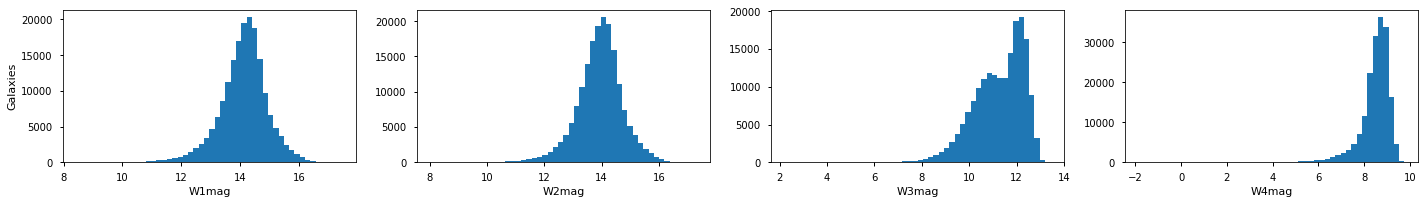

In [41]:
wise_apparent_mag_bands = [
    'W1mag',
    'W2mag',
    'W3mag',
    'W4mag',
]

fig, axes = plt.subplots(ncols=len(wise_apparent_mag_bands), figsize=(20, 3))
for axes_n, mag in enumerate(wise_apparent_mag_bands):
    axes[axes_n].hist(remove_bad_values(data[mag]), bins=50)
    axes[axes_n].set_xlabel(mag)
axes[0].set_ylabel('Galaxies')
fig.tight_layout()

In [42]:
wise_abs_mag_bands = [
    'W1_MAG_ABSOLUTE',
    'W2_MAG_ABSOLUTE',
    'W3_MAG_ABSOLUTE',
    'W4_MAG_ABSOLUTE'
]


# Note: these are not k-corrected
data['W1_MAG_ABSOLUTE'] = data['W1mag'] - data['DISTANCE_MODULUS']
data['W2_MAG_ABSOLUTE'] = data['W2mag'] - data['DISTANCE_MODULUS']
data['W3_MAG_ABSOLUTE'] = data['W3mag'] - data['DISTANCE_MODULUS']
data['W4_MAG_ABSOLUTE'] = data['W4mag'] - data['DISTANCE_MODULUS']

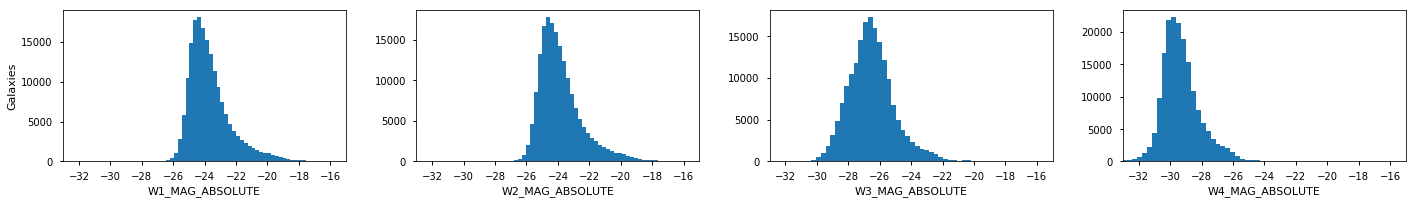

In [43]:
fig, axes = plt.subplots(ncols=len(wise_abs_mag_bands), figsize=(20, 3))
for axes_n, mag in enumerate(wise_abs_mag_bands):
    axes[axes_n].hist(remove_bad_values(data[mag]), bins=100)
    axes[axes_n].set_xlabel(mag)
    axes[axes_n].set_xlim([-33, -15])
axes[0].set_ylabel('Galaxies')
fig.tight_layout()

There are some REALLY bright W4 sources, if my crossmatching and cosmology is correct! I'm a little skeptical of the cross-match, but unsure how to check.

### SDSS Herschel Catalog

Ellison, S. L., Teimoorinia, H., Rosario, D. J., & Trevor Mendel, J. (2016). The infrared luminosities of ~332 000 SDSS galaxies predicted from artificial neural networks and the Herschel Stripe 82 survey. Monthly Notices of the Royal Astronomical Society, 455(1), 370–385. https://doi.org/10.1093/mnras/stv2275
    


> we repeat the training procedure 25 times and select the best 20 trained networks...The output of the best 20 trained networks show small differences due to the different initializations... for those galaxies in the SDSS sample that have very different [properties to Herschel-observed galaxies] the scatter will be very large...We adopt the mean LIR value of the 20 best trained networks, and assign the associated ‘error’ (σANN) as the scatter amongst the network outputs



In [44]:
fir_loc = 'catalogs/ellison_inferred_fir/LIR_select.out'

# schema from Table 2
columns = ['sdss_objid', 'ra', 'dec', 'z', 'log_lir', 'std_dev']
fir = pd.read_csv(fir_loc, header=None, names=columns, sep=' ')


In [45]:
print(len(fir))
fir.head()

331926


,sdss_objid,ra,dec,z,log_lir,std_dev
0,587722953304310243,237.26196,0.25983,0.03464,43.34,0.07
1,587722953304179097,236.88773,0.39001,0.11340,44.22,0.05
2,587722953304179083,236.88157,0.34449,0.03292,42.86,0.12
3,587722953304113519,236.77592,0.34773,0.03334,43.15,0.09
4,587722953303917041,236.36319,0.21511,0.10203,44.00,0.08


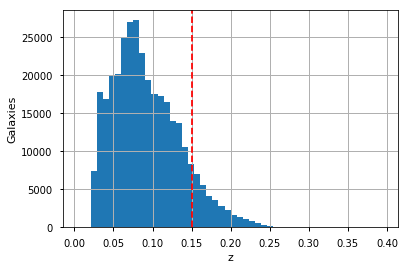

In [46]:
fir['z'].hist(bins=50)
plt.axvline(0.15, c='r', linestyle='--')
_ = plt.xlabel('z')
_ = plt.ylabel('Galaxies')

In [76]:
# check there are no duplicates
assert not np.sum(fir.duplicated())
assert not np.sum(fir.duplicated(subset=['sdss_objid']))
assert not np.sum(fir.duplicated(subset=['ra', 'dec']))

#### Cross-match into the core sample, but keep rows with missing data

In [53]:
data['ra'] = data['RA_1']
data['dec'] = data['DEC_1']

In [56]:
fir_data = Table.from_pandas(fir)

In [64]:
matched, unmatched = matching_utils.match_galaxies_to_catalog_table(
    fir_data, 
    data, 
    join_type='right',  # keep catalog rows even if they have no galaxy match
    matching_radius = 5 * units.arcsec, 
    galaxy_suffix='_fir')

In [66]:
assert len(matched) == len(data)

AssertionError: 

In [78]:
print(len(data))
print(len(matched))

180318
180338


In [79]:
sdss

['sdss_objid',
 'ra_fir',
 'dec_fir',
 'z',
 'log_lir',
 'std_dev',
 'best_match',
 'sky_separation',
 'IAUNAME',
 'SUBDIR',
 'RA_1',
 'DEC_1',
 'ISDSS',
 'INED',
 'ISIXDF',
 'IALFALFA',
 'IZCAT',
 'ITWODF',
 'MAG',
 'Z',
 'ZSRC',
 'SIZE',
 'RUN',
 'CAMCOL',
 'FIELD',
 'RERUN',
 'XPOS',
 'YPOS',
 'NSAID',
 'ZDIST',
 'SERSIC_NMGY',
 'SERSIC_NMGY_IVAR',
 'SERSIC_OK',
 'SERSIC_RNMGY',
 'SERSIC_ABSMAG',
 'SERSIC_AMIVAR',
 'EXTINCTION',
 'SERSIC_KCORRECT',
 'SERSIC_KCOEFF',
 'SERSIC_MTOL',
 'SERSIC_B300',
 'SERSIC_B1000',
 'SERSIC_METS',
 'SERSIC_MASS',
 'XCEN',
 'YCEN',
 'NPROF',
 'PROFMEAN',
 'PROFMEAN_IVAR',
 'QSTOKES',
 'USTOKES',
 'BASTOKES',
 'PHISTOKES',
 'PETRO_FLUX',
 'PETRO_FLUX_IVAR',
 'FIBER_FLUX',
 'FIBER_FLUX_IVAR',
 'PETRO_BA50',
 'PETRO_PHI50',
 'PETRO_BA90',
 'PETRO_PHI90',
 'SERSIC_FLUX',
 'SERSIC_FLUX_IVAR',
 'SERSIC_N',
 'SERSIC_BA',
 'SERSIC_PHI',
 'ASYMMETRY',
 'CLUMPY',
 'DFLAGS',
 'AID',
 'PID',
 'DVERSION',
 'PROFTHETA',
 'PETRO_THETA',
 'PETRO_TH50',
 'PETRO_TH90',

In [103]:
def check_id_fields_are_unique(data):
    for id_col in ['sdss_objid', 'sourceID', 'SDSS_ID', 'IAUNAME']:
        counts = Counter(list(filter(lambda x: x > 0, matched[id_col])))  # count all obj ids
        try:
            assert counts.most_common(1)[0][1] == 1  # most common id occurs only once
        except AssertionError:
            print(id_col)
            print(counts.most_common(10))
            return counts

In [106]:
bad_counts = check_id_fields_are_unique(data)

sourceID
[(433867090881, 2), (433866778994, 2), (433866480816, 2), (433850185607, 2), (433844941187, 2), (433848979960, 2), (433841308721, 2), (433848265656, 2), (433867982589, 2), (433829842203, 2)]


In [108]:
duplicate_source_id_tuples = filter(lambda x: x[1] > 1, counts.most_common(50))
duplicate_source_ids = [pair[0] for pair in duplicate_source_id_tuples]

[433867090881,
 433866778994,
 433866480816,
 433850185607,
 433844941187,
 433848979960,
 433841308721,
 433848265656,
 433867982589,
 433829842203,
 433842895193,
 433801324034,
 433819896232,
 433795602491,
 433812281474,
 433814342701,
 433809472664,
 433807130626,
 433793085638,
 433799447474]

In [110]:
duplicate_rows = data[data['sourceID'] == duplicate_source_ids[4]]
duplicate_rows

IAUNAME,SUBDIR,RA_1,DEC_1,ISDSS,INED,ISIXDF,IALFALFA,IZCAT,ITWODF,MAG,Z,ZSRC,SIZE,RUN,CAMCOL,FIELD,RERUN,XPOS,YPOS,NSAID,ZDIST,SERSIC_NMGY [7],SERSIC_NMGY_IVAR [7],SERSIC_OK,SERSIC_RNMGY [7],SERSIC_ABSMAG [7],SERSIC_AMIVAR [7],EXTINCTION [7],SERSIC_KCORRECT [7],SERSIC_KCOEFF [5],SERSIC_MTOL [7],SERSIC_B300,SERSIC_B1000,SERSIC_METS,SERSIC_MASS,XCEN,YCEN,NPROF [7],"PROFMEAN [15,7]","PROFMEAN_IVAR [15,7]","QSTOKES [15,7]","USTOKES [15,7]","BASTOKES [15,7]","PHISTOKES [15,7]",PETRO_FLUX [7],PETRO_FLUX_IVAR [7],FIBER_FLUX [7],FIBER_FLUX_IVAR [7],PETRO_BA50,PETRO_PHI50,PETRO_BA90,PETRO_PHI90,SERSIC_FLUX [7],SERSIC_FLUX_IVAR [7],SERSIC_N,SERSIC_BA,SERSIC_PHI,ASYMMETRY [7],CLUMPY [7],DFLAGS [7],AID,PID,DVERSION,PROFTHETA [15],PETRO_THETA,PETRO_TH50,PETRO_TH90,SERSIC_TH50,PLATE_1,FIBERID_1,MJD_1,RACAT,DECCAT,ZSDSSLINE,SURVEY,PROGRAMNAME,PLATEQUALITY,TILE,PLUG_RA,PLUG_DEC,ELPETRO_BA,ELPETRO_PHI,ELPETRO_FLUX_R,ELPETRO_FLUX_IVAR_R,ELPETRO_THETA_R,ELPETRO_TH50_R,ELPETRO_TH90_R,ELPETRO_THETA,ELPETRO_FLUX [7],ELPETRO_FLUX_IVAR [7],ELPETRO_TH50 [7],ELPETRO_TH90 [7],ELPETRO_APCORR_R,ELPETRO_APCORR [7],ELPETRO_APCORR_SELF [7],ELPETRO_NMGY [7],ELPETRO_NMGY_IVAR [7],ELPETRO_OK,ELPETRO_RNMGY [7],ELPETRO_ABSMAG [7],ELPETRO_AMIVAR [7],ELPETRO_KCORRECT [7],ELPETRO_KCOEFF [5],ELPETRO_MASS,ELPETRO_MTOL [7],ELPETRO_B300,ELPETRO_B1000,ELPETRO_METS,IN_DR7_LSS,JName,ra_xmatch,dec_xmatch,yAperMag3,j_1AperMag3,hAperMag3,kAperMag3,yAperMag3Err,j_1AperMag3Err,hAperMag3Err,kAperMag3Err,sourceID,mode,epoch,mergedClass,angDist,SDSS_ID,VEL_BALMER,VEL_BALMER_E,VEL_FORBIDDEN,VEL_FORBIDDEN_E,SIG_BALMER,SIG_BALMER_E,SIG_FORBIDDEN,SIG_FORBIDDEN_E,EBV_STAR,EBV_GAS,E_EBV_STAR,E_EBV_GAS,VEL_STARS,VEL_STARS_E,SIGMA_STARS,SIGMA_STARS_E,HEII_3203,NEV_3345,NEV_3425,OII_3726,OII_3728,NEIII_3868,NEIII_3967,H5_3889,HE_3970,HD_4101,HG_4340,OIII_4363,HEII_4685,ARIV_4711,ARIV_4740,HB_4861,OIII_4958,OIII_5006,NI_5197,NI_5200,HEI_5875,OI_6300,OI_6363,NII_6547,HA_6562,NII_6583,SII_6716,SII_6730,ARIII_7135,HEII_3203_ERROR,NEV_3345_ERROR,NEV_3425_ERROR,OII_3726_ERROR,OII_3728_ERROR,NEIII_3868_ERROR,NEIII_3967_ERROR,H5_3889_ERROR,HE_3970_ERROR,HD_4101_ERROR,HG_4340_ERROR,OIII_4363_ERROR,HEII_4685_ERROR,ARIV_4711_ERROR,ARIV_4740_ERROR,HB_4861_ERROR,OIII_4958_ERROR,OIII_5006_ERROR,NI_5197_ERROR,NI_5200_ERROR,HEI_5875_ERROR,OI_6300_ERROR,OI_6363_ERROR,NII_6547_ERROR,HA_6562_ERROR,NII_6583_ERROR,SII_6716_ERROR,SII_6730_ERROR,ARIII_7135_ERROR,AON_HEII_3203,AON_NEV_3345,AON_NEV_3425,AON_OII_3726,AON_OII_3728,AON_NEIII_3868,AON_NEIII_3967,AON_H5_3889,AON_HE_3970,AON_HD_4101,AON_HG_4340,AON_OIII_4363,AON_HEII_4685,AON_ARIV_4711,AON_ARIV_4740,AON_HB_4861,AON_OIII_4958,AON_OIII_5006,AON_NI_5197,AON_NI_5200,AON_HEI_5875,AON_OI_6300,AON_OI_6363,AON_NII_6547,AON_HA_6562,AON_NII_6583,AON_SII_6716,AON_SII_6730,AON_ARIII_7135,EW_HEII_3203,EW_NEV_3345,EW_NEV_3425,EW_OII_3726,EW_OII_3728,EW_NEIII_3868,EW_NEIII_3967,EW_H5_3889,EW_HE_3970,EW_HD_4101,EW_HG_4340,EW_OIII_4363,EW_HEII_4685,EW_ARIV_4711,EW_ARIV_4740,EW_HB_4861,EW_OIII_4958,EW_OIII_5006,EW_NI_5197,EW_NI_5200,EW_HEI_5875,EW_OI_6300,EW_OI_6363,EW_NII_6547,EW_HA_6562,EW_NII_6583,EW_SII_6716,EW_SII_6730,EW_ARIII_7135,FLAG_HEII_3203,FLAG_NEV_3345,FLAG_NEV_3425,FLAG_OII_3726,FLAG_OII_3728,FLAG_NEIII_3868,FLAG_NEIII_3967,FLAG_H5_3889,FLAG_HE_3970,FLAG_HD_4101,FLAG_HG_4340,FLAG_OIII_4363,FLAG_HEII_4685,FLAG_ARIV_4711,FLAG_ARIV_4740,FLAG_HB_4861,FLAG_OIII_4958,FLAG_OIII_5006,FLAG_NI_5197,FLAG_NI_5200,FLAG_HEI_5875,FLAG_OI_6300,FLAG_OI_6363,FLAG_NII_6547,FLAG_HA_6562,FLAG_NII_6583,FLAG_SII_6716,FLAG_SII_6730,FLAG_ARIII_7135,RN_SN,S_SN,NSIGMA,NSIGMA_OII_3726_3729,NSIGMA_HB_4861,NSIGMA_OIII_5007,NSIGMA_OI_6300,NSIGMA_OI_6363,NSIGMA_HA_NII_6547_6583,NSIGMA_SII_6716_6730,RA_2,DEC_2,REDSHIFT,PLATE_2,MJD_2,FIBERID_2,Separation,AllWISE,RAJ2000,DEJ2000,eeMaj,eeMin,eePA,W1mag,W2mag,W3mag,W4mag,Jmag,Hmag,Kmag,e_W1mag,e_W2mag,e_W3mag,e_W4mag,e_Jmag,e_Hmag,e_Kmag,ID,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,angDist_wisex,F_MAG_ABSOLUTE,N_MAG_ABSOLUTE,U_MAG_ABSOLUTE,G

In [105]:
check_id_fields_are_unique(matched)

sourceID
[(433867090881, 2), (433866778994, 2), (433866480816, 2), (433850185607, 2), (433844941187, 2), (433848979960, 2), (433841308721, 2), (433848265656, 2), (433867982589, 2), (433829842203, 2)]


### Save any newly-derived data

In [111]:
matched.write(data_loc.rstrip('.fits') + '_derived.fits', overwrite=True)